In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import L1Loss, MSELoss
from torchmetrics import MeanSquaredError, MeanAbsoluteError, R2Score, MeanAbsolutePercentageError
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy.stats import uniform, randint
from scipy.ndimage import gaussian_filter1d
# MLP imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
import sys
sys.path.append('..')
from utils import ml_parameters
from utils import settings as s
from utils.helper_functions import get_frequency_data, to_angular_freq
from utils.km_functions import km_get_drift, km_get_primary_control, km_get_diffusion
import csv
# define global imputer and scaler for preprocessing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
min_max_scaler = MinMaxScaler()

import matplotlib.pyplot as plt

In [2]:
files_prefix = 'ml_v3/'
if s.ml['random noise']:
    files_prefix = 'ml_v3_random_noise/'
elif s.ml['knockout']:
    files_prefix = 'ml_v3_knockout/'

def impute_scale(x: np.array) -> np.array:
    x = imp.transform(x)
    x = min_max_scaler.transform(x)
    return x

def evaluate_model(y_true: np.array, y_pred: np.array, model_type: str, dict_eval = None) -> None:
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if dict_eval is not None:
        dict_eval[model_type] = {
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'Mean Absolute Percentage Error': mape,
            'r2-Score': r2
        }
    with open(f'../results/{files_prefix}model_errors_v3.txt', mode='a') as file:
        file.write(f'\n{model_type}\n')
        file.write(f'Mean Squared Error: {mse}\n')
        file.write(f'Mean Absolute Error: {mae}\n')
        file.write(f'Mean Absolute Percentage Error: {mape}\n')
        file.write(f'r2-Score: {r2}\n')

In [5]:
mse_loss = MSELoss()
mae_loss = L1Loss()
mape_loss = MeanAbsolutePercentageError()
r2_score_torch = R2Score()

In [33]:
a = y_test[:10,:]*10
b = torch.randn(a.shape[0], 1)

In [35]:
from sklearn.metrics import r2_score

In [48]:
# target = torch.tensor([3, 3.05, 3.001])
# preds = torch.tensor([3.01, 3.0, 3])
# print(r2_score_torch(preds, target))
# print(r2_score(target, preds))
print(r2_score_torch(a, b))
print(r2_score(b.numpy(), a.numpy()))

tensor(-0.1098)
tensor([[-1.1826],
        [ 0.7826],
        [ 0.1115],
        [ 0.1041],
        [-1.1249],
        [ 0.4481],
        [-0.1395],
        [-2.5380],
        [ 0.3028],
        [ 0.8172]])
-0.10981905460357666
tensor([[-1.1826],
        [ 0.7826],
        [ 0.1115],
        [ 0.1041],
        [-1.1249],
        [ 0.4481],
        [-0.1395],
        [-2.5380],
        [ 0.3028],
        [ 0.8172]])


In [32]:
(a.numpy(), b.numpy())

(array([[0.00927677],
        [0.01165656],
        [0.00942263],
        [0.01376045],
        [0.01222769],
        [0.01106315],
        [0.01131823],
        [0.00928072],
        [0.01101454],
        [0.01200896]], dtype=float32),
 array([[-0.8022512 ],
        [ 0.4115858 ],
        [-0.46349332],
        [ 1.6461595 ],
        [ 1.6980212 ],
        [ 0.12456483],
        [-0.4104111 ],
        [ 1.5666637 ],
        [-0.7590886 ],
        [ 0.69486237]], dtype=float32))

In [3]:
class MLPRegressor(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = nn.MSELoss()(y_hat, y) #loss=mse
        mae = mae_loss(y, y_hat)
        mape = mape_loss(y, y_hat)
        r2 = r2_score_torch(y, y_hat)
        self.log('train_mse', loss, on_epoch=True, logger = True)
        self.log('train_mae', mae, on_epoch=True, logger = True)
        self.log('train_mape', mape, on_epoch=True, logger = True)
        self.log('train_r2', r2, on_epoch=True, logger = True)
        self.log('train_loss' , loss, prog_bar=True, on_step=False, on_epoch=True, logger = True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True, logger = True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = nn.MSELoss()(y_hat, y) #loss=mse
        mae = mae_loss(y, y_hat)
        mape = mape_loss(y, y_hat)
        r2 = r2_score_torch(y, y_hat)
        r2_sklearn = r2_score(y.detach().numpy(), y_hat.detach().numpy())
        self.log('test_mse', loss, on_epoch=True, logger = True)
        self.log('test_mae', mae, on_epoch=True, logger = True)
        self.log('test_mape', mape, on_epoch=True, logger = True)
        self.log('test_r2', r2, on_epoch=True, logger = True)
        self.log('test_r2_sklearn', r2_sklearn, on_epoch=True, logger = True)
        self.log('test_loss', loss, prog_bar=True, on_step=True, on_epoch=True, logger = True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

dict_eval = {}
for area in ['CE']:#['AUS', 'CE']:
    dict_eval[area] = {}
    y_complete = pd.DataFrame()
    y_complete_all = pd.DataFrame()

    data = pd.read_hdf(f'../results/prepared_features/{area}_detrended_ml.h5')

    feature_columns = [column for column in data.columns if column not in ['drift', 'diffusion']]
    X = data[feature_columns].copy()

    if s.ml['random noise']:
        np.random.seed(42)
        X['random_noise'] = np.random.rand(X.shape[0])

    for target in ['drift']: #['drift', 'diffusion']:
        dict_eval[area][target] = {}
        y = data[target]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42 # test_size=s.ml['test size']
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.25, random_state=42 # 0.25*0.8 = 0.2
        )

        # fit imputer and scaler
        imp.fit(X_train.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_train)
        min_max_scaler.fit(X_train.drop(columns=s.top_features[area][target]['mlp']).values if s.ml[
            'knockout'] else X_train.values)
        
        imp.fit(X_val.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_val)
        min_max_scaler.fit(X_val.drop(columns=s.top_features[area][target]['mlp']).values if s.ml[
            'knockout'] else X_val.values)
        
        imp.fit(X_test.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_test)
        min_max_scaler.fit(X_test.drop(columns=s.top_features[area][target]['mlp']).values if s.ml[
            'knockout'] else X_test.values)

        X_train = impute_scale(X_train.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_train)
        X_val = impute_scale(X_val.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_val)
        X_test = impute_scale(X_test.drop(columns=s.top_features[area][target]['mlp']) if s.ml['knockout'] else X_test)
        # # Example dataset
        # X_train = torch.randn(100, 10)  # 100 samples, 10 features
        # y_train = torch.randn(100, 1)   # 100 samples, 1 target
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train=torch.reshape(torch.tensor(y_train, dtype=torch.float32), (-1, 1))
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val=torch.reshape(torch.tensor(y_val, dtype=torch.float32), (-1, 1))
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test=torch.reshape(torch.tensor(y_test, dtype=torch.float32), (-1, 1))
    

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        test_dataset = TensorDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

        # Define the parameter grid for W&B sweep
        sweep_config = {
            'method': 'grid',  # or 'random'
            'parameters': {
                'hidden_dim': {
                    'values': [32, 64, 128]
                },
                'learning_rate': {
                    'values': [0.001, 0.01, 0.1]
                }
            }
        }
        # wandb.login()
        # sweep_id = wandb.sweep(sweep_config, project='test_drift_mlp')

        # def train_model(config=None):
        #     with wandb.init(config=config):
        #         config = wandb.config
        #         model = MLPRegressor(input_dim=X_train.shape[1], hidden_dim=config.hidden_dim, output_dim=y_train.shape[1], learning_rate=config.learning_rate)
                
        #         # log model only if `val_accuracy` increases
        #         wandb_logger = WandbLogger(log_model="all")
        #         early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="min")
        #         #checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min")
        #         trainer = pl.Trainer(max_epochs=20, logger = wandb_logger, callbacks=[early_stop_callback]) #20 #100
        #         trainer.fit(model, train_loader, val_loader)
        #         trainer.test(model, test_loader)

        # wandb.agent(sweep_id, train_model, count=10)

C:\Users\bt8891\AppData\Local\Temp\ipykernel_5116\497371713.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train=torch.reshape(torch.tensor(y_train, dtype=torch.float32), (-1, 1))
C:\Users\bt8891\AppData\Local\Temp\ipykernel_5116\497371713.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val=torch.reshape(torch.tensor(y_val, dtype=torch.float32), (-1, 1))
C:\Users\bt8891\AppData\Local\Temp\ipykernel_5116\497371713.py:106: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

In [21]:
minmaxscaler = MinMaxScaler()
test = np.array([7, 8, 9]).reshape(-1, 1)
minmaxscaler.fit(test)
test_2 = np.array([1,2,3]).reshape(-1, 1)
print(minmaxscaler.transform(test_2))

[[-3. ]
 [-2.5]
 [-2. ]]


In [22]:
standardscaler = StandardScaler()
standardscaler.fit(test)
print(standardscaler.transform(test_2))

[[-8.5732141 ]
 [-7.34846923]
 [-6.12372436]]


# Test auf Nan's und richtiger Zeitzone in den Daten

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

def impute_scale(x: np.array) -> np.array:
    x = imp.transform(x)
    x = min_max_scaler.transform(x)
    return x

In [5]:


dict_eval = {}
for area in ['CE']:#['AUS', 'CE']:
    dict_eval[area] = {}
    y_complete = pd.DataFrame()
    y_complete_all = pd.DataFrame()

    data = pd.read_hdf(f'../results/prepared_features/{area}_detrended_ml.h5')

    feature_columns = [column for column in data.columns if column not in ['drift', 'diffusion']]
    X = data[feature_columns].copy()

    if s.ml['random noise']:
        np.random.seed(42)
        X['random_noise'] = np.random.rand(X.shape[0])

    for target in ['drift']: #['drift', 'diffusion']:
        dict_eval[area][target] = {}
        y = data[target]

        # valid_ind = ~pd.concat([X, y], axis=1).isnull().any(axis=1)
        # X, y = X[valid_ind], y[valid_ind]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=s.ml['test size'], random_state=42
)

In [72]:
X_train.isna().any(axis=1).sum()/len(X_train)
X_train.isna().sum().sum()

np.int64(31586)

In [21]:
def fit_linear_regression(X_train: np.array, y_train: np.array) -> np.array:
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.score(X_train, y_train)
score_lin_reg = []
for lag in range(25):
    if lag == 24:
        X_train = X.iloc[lag:,:]
    else:
        X_train = X.iloc[lag:-(24-lag),:]
    y_train = y.iloc[12:-(24-12)]
    imp.fit(X_train)
    min_max_scaler.fit(X_train.values)
    X_train = impute_scale(X_train)
    score_lin_reg.append(fit_linear_regression(X_train, y_train))

[0.31415608 0.31380879 0.31346022 0.31205094 0.31112272 0.31044711
 0.31747395 0.32685565 0.33496608 0.34521616 0.3543243  0.36060998
 0.36574859 0.36317192 0.35893395 0.35404651 0.34760955 0.34249966
 0.33488587 0.33307909 0.33066237 0.32539975 0.32170232 0.32108116
 0.320793  ]


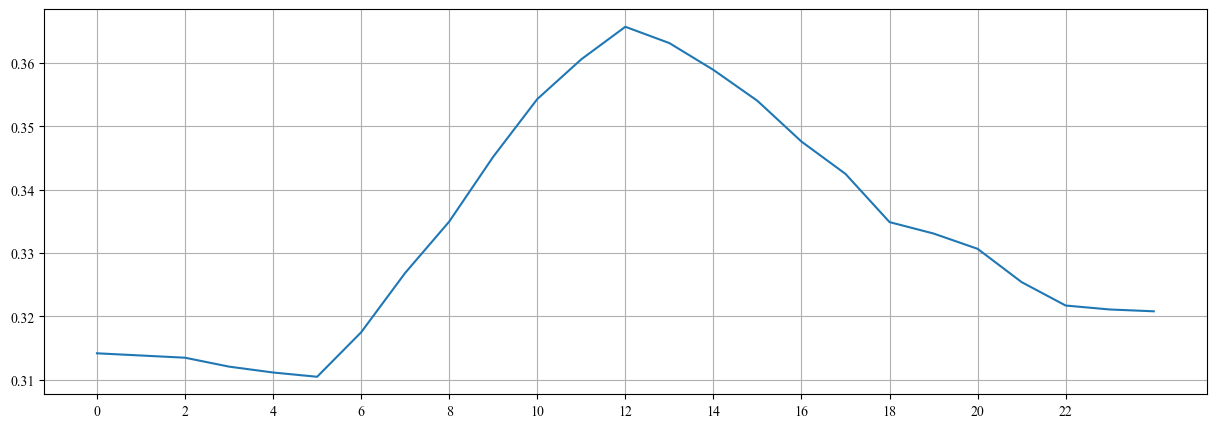

In [22]:
print(np.array(score_lin_reg))
plt.figure(figsize=(15,5))
plt.plot(score_lin_reg)
plt.xticks(range(0,24,2))
plt.grid()
plt.show()

In [185]:
plt.plot(X_train.T)

 ...]

Error in callback <function flush_figures at 0x000001F807234EA0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

# Test data time

In [3]:
import pandas as pd
freq_CE = pd.read_hdf(f'../data/cleansed_2015-01-01_to_2019-12-31.h5')

In [4]:
def get_frequency_data(country: str) -> pd.DataFrame:
    """
    Returns frequency data for a given country without NaN values and only those hours
    that have no missing measurements
    """
    if country == 'AUS':
        df = pd.read_hdf('../data/AUS_cleansed_frequency_data.h5')

    elif country == 'CE':
        # ce_data = h5py.File(f'../data/CE_cleansed_2015-01-01_to_2019-12-31.h5', 'r')['df']
        # df = pd.DataFrame({'timestamp': ce_data['index'], 'frequency': ce_data['values']})
        ce_data = pd.read_hdf(f'../data/cleansed_2015-01-01_to_2019-12-31.h5')#, key='df') #!!! this is added	
        #df = pd.DataFrame({'timestamp': ce_data.index, 'frequency': ce_data.values}) #!!! this is added	
        #df = ce_data[['timestamp', 'frequency']] #!!! this is added
        #df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = ce_data
        #df.dropna(how='any', inplace=True)
        df = df.dropna()
        # remove data before dip in drift dip at 2017-01-25 04:00:00,
        # but some missing data until 2017-03-13 00:00:00
        
        #df = df[df['timestamp'] >= '2017-03-13 00:00:00']
        df = df[df.index >= '2017-03-13 00:00:00']

    else:
        print('Invalid country')
        return pd.DataFrame()
    df['timestamp'] = df.index
    # add datetime rounded down to hour to each datapoint
    # df['hour'] = df['timestamp'].dt.floor('h', ambiguous=True) #!!! ambiguous=True is added; with this method, we lose at the moment the hours of time changing (DST) !!!

    # # Group by date and hour and filter out hours that don't have enough data points # !!! replaced !!!
    # hourly_amount = df.groupby('hour').size()
    # uninterrupted_hours_index = hourly_amount[hourly_amount == s.settings[country]['values per hour']].index
    # df = df[df['hour'].isin(uninterrupted_hours_index)]

    # # Alternatively:
    # # df_grouped = df.groupby('hour')
    # # df = df_grouped.filter(lambda x: len(x) == 3600)
    return df

In [5]:
area = 'CE'
freq = get_frequency_data(area)

KeyboardInterrupt: 

In [ ]:
145026373

In [6]:
freq.dropna(how='any', inplace=True)

# Test 01_drift_ ...

In [11]:
n = 100

In [30]:
angular_freq = to_angular_freq(freq.iloc[:3600*n,:], area)

# for datatype in ['detrended']:
datatype = 'detrended'
frequency = angular_freq['frequency']

# frequency measurements/values per hour
vph = s.settings[area]['values per hour']
hours = frequency.size // vph
drifts = np.empty(hours)
diffusions = np.empty(hours)

# detrend data
if datatype == 'detrended':
    data_filter = gaussian_filter1d(frequency, sigma=s.settings[area]['detrend sigma'])
    frequency = frequency - data_filter

In [31]:
# calculate the drift and diffusion for each hour
for i in range(n):#(hours):
    drift, space = km_get_drift(
        frequency[vph * i:vph * i + vph], s.km[area]['drift bw'], s.km[area]['delta_t']
    )
    drifts[i] = km_get_primary_control(drift, space)
    diffusions[i] = km_get_diffusion(
        frequency[vph * i:vph * i + vph], s.km[area]['diffusion bw'], s.km[area]['delta_t']
    )

# store the results
index = angular_freq['hour'].unique()
drift_diffusion = pd.DataFrame({'drift': drifts, 'diffusion': diffusions}, index=index)
    #drift_diffusion.to_hdf(f'../results/km/{area}_{datatype}_drift_diffusion.h5', key='df', mode='w')

### Alternative

In [12]:
area = 'CE'
df = freq.iloc[:3600*n,:]
df_test = df.copy()
df_test = to_angular_freq(df_test, area)
test_group = df_test.groupby('hour')
frequency = df_test['frequency']
if datatype == 'detrended':
    data_filter = gaussian_filter1d(frequency, sigma=s.settings[area]['detrend sigma'])
    frequency = frequency - data_filter
    df_test['frequency'] = frequency

NameError: name 'freq' is not defined

In [13]:
j = 0
index = []
means = []
drifts = np.zeros(n)
diffusions = np.zeros(n)
segment_length = []
j = 0
def fun_drift(df):
    drift, space = km_get_drift(
        df['frequency'], s.km[area]['drift bw'], s.km[area]['delta_t']
    )
    return km_get_primary_control(drift, space)
def fun_diffusion(df):
    return km_get_diffusion(
        df['frequency'], s.km[area]['diffusion bw'], s.km[area]['delta_t']
    )
# for segment in test_group:
#     if j < n:
#         frequency = segment[1]['frequency']
#         drift, space = km_get_drift(
#             frequency, s.km[area]['drift bw'], s.km[area]['delta_t']
#         )
#         drifts[j] = (km_get_primary_control(drift, space))
#         diffusions[j] = (km_get_diffusion(
#             frequency, s.km[area]['diffusion bw'], s.km[area]['delta_t']
#         ))
#         #index.append(segment[0])
#         #     means.append(segment[1]['frequency'].mean())
#         j+=1
#     else:
#         break
test_drift = test_group.apply(lambda x: fun_drift(x))
test_diffusion = test_group.apply(lambda x: fun_diffusion(x))
# print(j)

NameError: name 'test_group' is not defined

In [54]:
pd.concat([test_drift, test_diffusion], axis=1, keys=['drift', 'diffusion'])

,drift,diffusion
hour,,
2017-03-13 00:00:00+01:00,0.016826,0.046869
2017-03-13 01:00:00+01:00,0.013255,0.027157
2017-03-13 02:00:00+01:00,0.008008,0.030270
2017-03-13 03:00:00+01:00,0.006902,0.041822
2017-03-13 04:00:00+01:00,0.017489,0.032173
...,...,...
2017-10-07 16:00:00+02:00,0.013161,0.066085
2017-10-07 17:00:00+02:00,0.009008,0.058894
2017-10-07 18:00:00+02:00,0.019058,0.051716


In [33]:
test_drift, drifts

(hour
 2017-03-13 00:00:00+01:00    0.016826
 2017-03-13 01:00:00+01:00    0.013255
 2017-03-13 02:00:00+01:00    0.008008
 2017-03-13 03:00:00+01:00    0.006902
 2017-03-13 04:00:00+01:00    0.017489
                                ...   
 2017-06-04 15:00:00+02:00    0.017579
 2017-06-04 16:00:00+02:00    0.007221
 2017-06-04 17:00:00+02:00    0.018213
 2017-06-04 18:00:00+02:00    0.025310
 2017-06-04 19:00:00+02:00    0.025954
 Length: 2000, dtype: float64,
 array([0.01682558, 0.01325501, 0.00800804, ..., 0.01821254, 0.02531006,
        0.02595358]))

In [26]:
drifts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# Test get_frequency_data from helper_functions

In [10]:
input_actual = pd.read_hdf(f'../data/[feature_data]/CE/input_actual.h5')
input_forecast = pd.read_hdf(f'../data/[feature_data]/CE/input_forecast.h5')
features = pd.concat([input_actual, input_forecast], axis=1)

In [ ]:
features_CE.index - pd.Timedelta(hours=0)

DatetimeIndex(['2015-01-01 01:00:00+01:00', '2015-01-01 02:00:00+01:00', '2015-01-01 03:00:00+01:00', '2015-01-01 04:00:00+01:00', '2015-01-01 05:00:00+01:00', '2015-01-01 06:00:00+01:00', '2015-01-01 07:00:00+01:00', '2015-01-01 08:00:00+01:00', '2015-01-01 09:00:00+01:00', '2015-01-01 10:00:00+01:00',
               ...
               '2019-12-30 16:00:00+01:00', '2019-12-30 17:00:00+01:00', '2019-12-30 18:00:00+01:00', '2019-12-30 19:00:00+01:00', '2019-12-30 20:00:00+01:00', '2019-12-30 21:00:00+01:00', '2019-12-30 22:00:00+01:00', '2019-12-30 23:00:00+01:00', '2019-12-31 00:00:00+01:00', '2019-12-31 01:00:00+01:00'], dtype='datetime64[ns, CET]', length=43801, freq=None)

In [25]:
freq_CE.index
features_CE
features_CE.index = features_CE.index.tz_localize(None).tz_localize('CET', ambiguous=True)# - pd.Timedelta(hours=2)

,drift,diffusion
hour,,
2017-03-13 00:00:00+01:00,0.010041,0.000028
2017-03-13 01:00:00+01:00,0.009126,0.000025
2017-03-13 02:00:00+01:00,0.008127,0.000023
2017-03-13 03:00:00+01:00,0.011268,0.000025
2017-03-13 04:00:00+01:00,0.011054,0.000023
...,...,...
2019-12-31 19:00:00+01:00,0.008438,0.000018
2019-12-31 20:00:00+01:00,0.008458,0.000016
2019-12-31 21:00:00+01:00,0.009017,0.000016


In [7]:
ce_data = pd.read_hdf(f'../data/cleansed_2015-01-01_to_2019-12-31.h5', key='df') #!!! this is added	
df = pd.DataFrame({'timestamp': ce_data.index, 'frequency': ce_data.values}) #!!! this is added	
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dropna(how='any', inplace=True)
# remove data before dip in drift dip at 2017-01-25 04:00:00,
# but some missing data until 2017-03-13 00:00:00
df = df[df['timestamp'] >= '2017-03-13 00:00:00']
df['hour'] = df['timestamp'].dt.floor('h', ambiguous = True) #!!! ambiguous=True is added; with this method, we lose at the moment the hours of time changing (DST)

KeyboardInterrupt: 

In [35]:
country = 'CE'
hourly_amount = df.groupby('hour').size()
uninterrupted_hours_index = hourly_amount[hourly_amount == s.settings[country]['values per hour']].index
df = df[df['hour'].isin(uninterrupted_hours_index)]

In [37]:
df

,timestamp,frequency,hour
69292800,2017-03-13 00:00:00+01:00,50.028000,2017-03-13 00:00:00+01:00
69292801,2017-03-13 00:00:01+01:00,50.027000,2017-03-13 00:00:00+01:00
69292802,2017-03-13 00:00:02+01:00,50.028999,2017-03-13 00:00:00+01:00
69292803,2017-03-13 00:00:03+01:00,50.028000,2017-03-13 00:00:00+01:00
69292804,2017-03-13 00:00:04+01:00,50.028000,2017-03-13 00:00:00+01:00
...,...,...,...
157766395,2019-12-31 23:59:55+01:00,50.027000,2019-12-31 23:00:00+01:00
157766396,2019-12-31 23:59:56+01:00,50.027000,2019-12-31 23:00:00+01:00
157766397,2019-12-31 23:59:57+01:00,50.027000,2019-12-31 23:00:00+01:00
157766398,2019-12-31 23:59:58+01:00,50.028000,2019-12-31 23:00:00+01:00


In [22]:
df_test = df.copy()
df_test.set_index('timestamp', inplace=True)
test_group = df_test.groupby('hour')#.count()==3600
test = test_group.filter(lambda x: len(x) == 3600)
#df_test.index = df_test.index.tz_convert('utc')
#df_test['hour'] = df_test.index.floor('h', ambiguous = True)
#df_test.index = df_test.index.tz_convert('CET')
#test = pd.DatetimeIndex(df_test['hour'].values).tz_localize('utc').tz_convert('CET')
#df_test['hour'] = test

,frequency,hour
timestamp,,
2017-10-29 02:59:59+01:00,50.049999,2017-10-29 02:00:00+02:00
2017-10-29 03:00:00+01:00,50.049999,2017-10-29 03:00:00+01:00
2017-10-29 03:00:01+01:00,50.049000,2017-10-29 03:00:00+01:00
2017-10-29 03:00:02+01:00,50.049000,2017-10-29 03:00:00+01:00
2017-10-29 03:00:03+01:00,50.047001,2017-10-29 03:00:00+01:00
...,...,...
2019-12-31 23:59:55+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:56+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:57+01:00,50.027000,2019-12-31 23:00:00+01:00


In [23]:
df_test.loc['2017-10-29 02:59:59+02:00':]

,frequency,hour
timestamp,,
2017-10-29 02:59:59+02:00,50.040001,2017-10-29 02:00:00+02:00
2017-10-29 02:00:00+01:00,50.040001,2017-10-29 02:00:00+02:00
2017-10-29 02:00:01+01:00,50.041000,2017-10-29 02:00:00+02:00
2017-10-29 02:00:02+01:00,50.040001,2017-10-29 02:00:00+02:00
2017-10-29 02:00:03+01:00,50.037998,2017-10-29 02:00:00+02:00
...,...,...
2019-12-31 23:59:55+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:56+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:57+01:00,50.027000,2019-12-31 23:00:00+01:00


In [7]:
# hourly_groups = df_test.groupby(df_test.index.hour)

# # Step 3: Filter out incomplete hours 
# valid_hours = hourly_groups.filter(lambda x: len(x) == 3600)

In [21]:
# country = 'CE'
# hourly_amount = df_test.groupby().size()
# uninterrupted_hours_index = hourly_amount[hourly_amount == s.settings[country]['values per hour']].index
# df_test = df_test[df_test['hour'].isin(uninterrupted_hours_index)]

In [68]:
# df_test.index.tz_convert('utc')

In [38]:
test_group = df_test.groupby('hour')#.count()==3600
#test_group = df_test.resample('H')#('hour')#.count()==3600
#test_group.value_counts().sort_values()
test_group

In [26]:
# valid_hours = test_group.apply(lambda x: len(x) == 7200)

In [39]:
test = test_group.filter(lambda x: len(x) == 3600)

In [40]:
test

,frequency,hour
timestamp,,
2017-03-13 00:00:00+01:00,50.028000,2017-03-13 00:00:00+01:00
2017-03-13 00:00:01+01:00,50.027000,2017-03-13 00:00:00+01:00
2017-03-13 00:00:02+01:00,50.028999,2017-03-13 00:00:00+01:00
2017-03-13 00:00:03+01:00,50.028000,2017-03-13 00:00:00+01:00
2017-03-13 00:00:04+01:00,50.028000,2017-03-13 00:00:00+01:00
...,...,...
2019-12-31 23:59:55+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:56+01:00,50.027000,2019-12-31 23:00:00+01:00
2019-12-31 23:59:57+01:00,50.027000,2019-12-31 23:00:00+01:00


In [29]:
test_group = df_test.groupby('hour')
j = 0
index = []
means = []
segment_length = []
for segment in test_group:
    # if segment[1].shape[0] == 3600:
    #     j+=1
    #     index.append(segment[0])
    #     means.append(segment[1]['frequency'].mean())
    segment_length.append(segment[1].shape[0])
print(j)

0


In [31]:
pd.Series(segment_length).value_counts().sort_index()

6           1
7          21
3059        1
3150        1
3239        1
        ...  
3594        5
3596        3
3599       22
3600    23651
7200        3
Name: count, Length: 65, dtype: int64

In [11]:
919 - 794

125

In [47]:
pd.DatetimeIndex(index)
test_final_df = pd.DataFrame({'means': means}, index=pd.DatetimeIndex(index))

In [54]:
print(test_final_df.shape, features_CE.shape)
test_final_df
features_CE.join(test_final_df, how='inner')

(23651, 1) (43801, 48)


,gen_hard_coal,gen_reservoir_hydro,gen_other,gen_wind_on,gen_waste,gen_solar,gen_other_renew,gen_nuclear,gen_run_off_hydro,gen_pumped_hydro,gen_geothermal,gen_gas,gen_lignite,gen_biomass,gen_wind_off,gen_oil,load,gen_coal_gas,total_gen,load_ramp,total_gen_ramp,hard_coal_ramp,reservoir_hydro_ramp,other_ramp,wind_on_ramp,waste_ramp,solar_ramp,other_renew_ramp,nuclear_ramp,run_off_hydro_ramp,pumped_hydro_ramp,geothermal_ramp,gas_ramp,lignite_ramp,biomass_ramp,wind_off_ramp,oil_ramp,coal_gas_ramp,forecast_error_total_gen,forecast_error_load,forecast_error_load_ramp,forecast_error_total_gen_ramp,forecast_error_wind_on_ramp,forecast_error_wind_on,forecast_error_wind_off,forecast_error_wind_off_ramp,forecast_error_solar_ramp,forecast_error_solar,means
2017-03-13 00:00:00+01:00,17258.9300,3230.0700,12631.5100,33075.8575,1381.9850,316.78,666.5875,78688.4350,16347.1150,703.3225,707.4100,21145.6325,31992.4375,7462.7050,2988.3950,1011.4700,235502.3350,297.90,229906.5425,-14688.0675,-9186.7700,-1437.4050,-1171.9450,-336.1875,-1587.2625,-24.3300,-22.98,-5.3225,-323.6200,-916.5475,-737.9175,-2.7200,-1570.3250,-782.5900,-61.1425,-206.6675,0.5225,-0.33,2370.1900,2234.0025,3210.4800,-1208.5225,237.7100,-4275.3050,-30.7650,-16.6925,-55.11,-96.17,50.013058
2017-03-13 01:00:00+01:00,16682.6900,3060.0800,11854.6225,31775.5950,1373.3150,171.78,667.8875,78418.0575,16077.0900,851.5425,707.5225,20535.8375,31698.3275,7418.4450,2639.4600,1011.4125,226841.3575,298.32,225241.9850,-8660.9775,-4664.5575,-576.2400,-169.9900,-776.8875,-1300.2625,-8.6700,-145.00,1.3000,-270.3775,-270.0250,148.2200,0.1125,-609.7950,-294.1100,-44.2600,-348.9350,-0.0575,0.42,571.8525,695.5300,-1538.4725,-1798.3375,-187.3875,-4462.6925,51.3500,82.1150,40.69,-55.48,49.998856
2017-03-13 02:00:00+01:00,16035.1275,2597.0375,11363.3650,30709.9025,1371.7500,95.78,663.9725,78013.0200,16163.2325,665.5475,707.5800,20050.9225,31956.1875,7430.6175,2278.5275,1007.6975,222167.1700,297.54,221407.8075,-4674.1875,-3834.1775,-647.5625,-463.0425,-491.2575,-1065.6925,-1.5650,-76.00,-3.9150,-405.0375,86.1425,-185.9950,0.0575,-484.9150,257.8600,12.1725,-360.9325,-3.7150,-0.78,359.7050,965.6925,270.1625,-212.1475,-170.3425,-4633.0350,58.9525,7.6025,42.41,-13.07,49.997624
2017-03-13 03:00:00+01:00,17236.8925,2090.8425,11349.8325,29759.7425,1374.8650,95.78,663.8850,78078.1650,15981.6475,683.0075,707.6675,20365.2800,32494.8900,7428.8825,2080.5250,1005.8600,219871.0225,298.01,221695.7750,-2296.1475,287.9675,1201.7650,-506.1950,-13.5325,-950.1600,3.1150,0.00,-0.0875,65.1450,-181.5850,17.4600,0.0875,314.3575,538.7025,-1.7350,-198.0025,-1.8375,0.47,-1349.6250,-298.5375,-1264.2300,-1709.3300,206.7825,-4426.2525,-6.4150,-65.3675,14.09,1.02,49.997480
2017-03-13 04:00:00+01:00,19342.7975,2256.5825,11823.4950,29313.4675,1372.7800,95.80,662.1700,77504.7450,15851.1900,364.7775,707.3650,21450.6725,33107.4175,7455.7475,1831.5175,1003.4550,224710.9725,299.59,224443.5700,4839.9500,2747.7950,2105.9050,165.7400,473.6625,-446.2750,-2.0850,0.02,-1.7150,-573.4200,-130.4575,-318.2300,-0.3025,1085.3925,612.5275,26.8650,-249.0075,-2.4050,1.58,-888.3175,-1511.4450,-1212.9075,461.3075,80.5000,-4345.7525,17.6625,24.0775,-79.72,-78.70,49.991952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-30 21:00:00+01:00,14390.7500,15787.7175,6756.2850,45584.9175,1655.1000,36.55,644.2275,83311.0250,22940.2700,3745.9225,695.3500,44729.5150,18397.5500,8131.4975,6883.9700,1333.0600,291640.0175,270.49,275294.1975,-13142.9050,-8668.7050,-771.4300,-2109.6550,-563.4375,-343.6725,5.7000,-1.40,0.9200,159.5500,-1481.5900,-1547.6200,1.2075,-1744.1900,-638.4100,-21.3900,387.0000,1.0725,-1.36,-12504.8750,-3158.0175,-825.6725,-2429.2225,-54.7175,-4964.5775,561.7325,-745.7325,-1.10,-12.00,49.994031
2019-12-30 22:00:00+01:00,13730.4225,14057.9500,6266.7200,44620.8375,1662.3550,36.55,643.5550,83168.2400,

In [71]:
test_group.loc['2017-10-29 00:59:59+02:00':]

,frequency
hour,
2017-10-29 01:00:00+02:00,3600
2017-10-29 02:00:00+02:00,7200
2017-10-29 03:00:00+01:00,3600
2017-10-29 04:00:00+01:00,3600
2017-10-29 05:00:00+01:00,3600
...,...
2019-12-31 19:00:00+01:00,3600
2019-12-31 20:00:00+01:00,3600
2019-12-31 21:00:00+01:00,3600


In [57]:
#df['hour'] = df['timestamp'].dt.floor('h', ambiguous=True)
# Group by date and hour and filter out hours that don't have enough data points
hourly_amount = df.groupby('hour').size()
uninterrupted_hours_index = hourly_amount[hourly_amount == s.settings['CE']['values per hour']].index
df = df[df['hour'].isin(uninterrupted_hours_index)]
freq=df
angular_freq = to_angular_freq(freq, area)

c:\Users\bt8891\AppData\Local\miniconda3\envs\drift\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [60]:
index = angular_freq['hour'].unique()
index

<DatetimeArray>
['2017-03-13 00:00:00+01:00', '2017-03-13 01:00:00+01:00', '2017-03-13 02:00:00+01:00', '2017-03-13 03:00:00+01:00', '2017-03-13 04:00:00+01:00', '2017-03-13 05:00:00+01:00', '2017-03-13 06:00:00+01:00', '2017-03-13 07:00:00+01:00', '2017-03-13 08:00:00+01:00', '2017-03-13 09:00:00+01:00',
 ...
 '2019-12-31 14:00:00+01:00', '2019-12-31 15:00:00+01:00', '2019-12-31 16:00:00+01:00', '2019-12-31 17:00:00+01:00', '2019-12-31 18:00:00+01:00', '2019-12-31 19:00:00+01:00', '2019-12-31 20:00:00+01:00', '2019-12-31 21:00:00+01:00', '2019-12-31 22:00:00+01:00', '2019-12-31 23:00:00+01:00']
Length: 23651, dtype: datetime64[ns, CET]

In [61]:
area = 'CE'
datatype = 'detrended'
targets = pd.read_hdf(f'../results/km/{area}_{datatype}_drift_diffusion.h5')
targets#.index.tz_localize('CET', ambiguous='NaT')

,drift,diffusion
hour,,
2017-03-13 00:00:00+01:00,0.010041,0.000028
2017-03-13 01:00:00+01:00,0.009126,0.000025
2017-03-13 02:00:00+01:00,0.008127,0.000023
2017-03-13 03:00:00+01:00,0.011268,0.000025
2017-03-13 04:00:00+01:00,0.011054,0.000023
...,...,...
2019-12-31 19:00:00+01:00,0.008438,0.000018
2019-12-31 20:00:00+01:00,0.008458,0.000016
2019-12-31 21:00:00+01:00,0.009017,0.000016


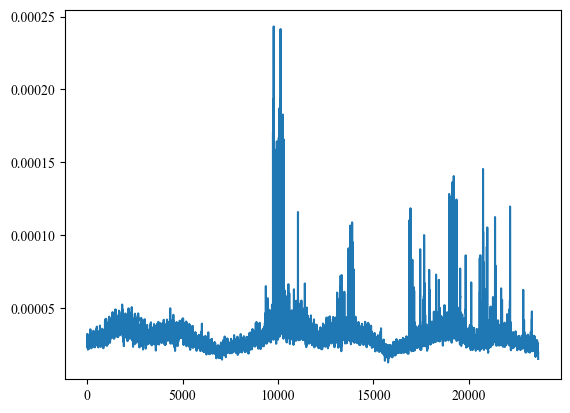

In [60]:
plt.plot(targets['diffusion'].values)


In [86]:
rng_tz = pd.DatetimeIndex(["2021-10-31 02:30:00+01:00"], tz="Europe/Amsterdam")
print(rng_tz)
rng_tz.floor("h", ambiguous=False)

DatetimeIndex(['2021-10-31 02:30:00+01:00'], dtype='datetime64[ns, Europe/Amsterdam]', freq=None)


DatetimeIndex(['2021-10-31 02:00:00+01:00'], dtype='datetime64[ns, Europe/Amsterdam]', freq=None)

# Compare drift and diffusion

In [8]:
area = 'CE'
datatype = 'detrended'
drift_and_diff = pd.read_hdf(f'../results/km/{area}_{datatype}_drift_diffusion.h5', key='df', ambiguous=True, parse_dates=True, tz='CET') 
drift_and_diff
drift_and_diff_old = pd.read_hdf(f'../results/km/old_files/{area}_{datatype}_drift_diffusion.h5', key='df', ambiguous=True, parse_dates=True, tz='CET') 

In [9]:
'''These functions serve for the alternative calculation of the drift and diffusion'''
def fun_drift(df):
    drift, space = km_get_drift(
        df['frequency'], s.km[area]['drift bw'], s.km[area]['delta_t']
        
    )
    return km_get_primary_control(drift, space)
def fun_diffusion(df):
    return km_get_diffusion(
        df['frequency'], s.km[area]['diffusion bw'], s.km[area]['delta_t']
    )

In [9]:
freq = freq_CE
freq_old = get_frequency_data(area)

In [16]:
#df['timestamp'] = pd.to_datetime(df['timestamp'])
freq.dropna(how='any', inplace=True)
# remove data before dip in drift dip at 2017-01-25 04:00:00,
# but some missing data until 2017-03-13 00:00:00
freq = freq[freq.index >= '2017-03-13 00:00:00']

In [23]:
# '''Compare the frequency data calculation'''
# pd.Series(freq_old['frequency'].values-freq.values).value_counts()

In [24]:
test = freq_old.copy()
test.set_index('timestamp', inplace=True)
test['frequency'] = (test['frequency']-50)*2*np.pi

In [ ]:
a = 1
snippet = test.iloc[a*3600:(a+1)*3600,:]
datatype = 'detrended'
frequency = snippet['frequency'] 
if datatype == 'detrended':
    data_filter = gaussian_filter1d(frequency, sigma=s.settings[area]['detrend sigma'])
    frequency = frequency - data_filter
    snippet['frequency'] = frequency

fun_drift(snippet), fun_diffusion(snippet)

C:\Users\bt8891\AppData\Local\Temp\ipykernel_24844\41165437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snippet['frequency'] = frequency


(np.float64(0.008353717971060383), np.float64(2.4981487118314977e-05))

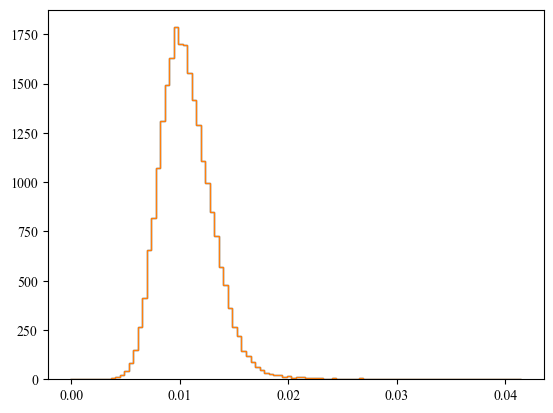

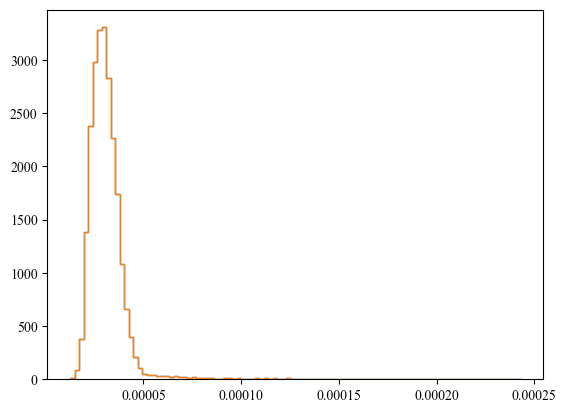

In [11]:
drift_and_diff_old,drift_and_diff
plt.hist(drift_and_diff['drift'], bins=100, histtype='step')
plt.hist(drift_and_diff_old['drift'], bins=100, histtype='step')
plt.show()
plt.hist(drift_and_diff['diffusion'], bins=100, histtype='step')
plt.hist(drift_and_diff_old['diffusion'], bins=100, histtype='step')
plt.show()

In [21]:
drift_and_diff_old,drift_and_diff

(                        drift  diffusion
 2017-03-13 00:00:00  0.009186   0.000025
 2017-03-13 01:00:00  0.008127   0.000023
 2017-03-13 02:00:00  0.011268   0.000025
 2017-03-13 03:00:00  0.011054   0.000023
 2017-03-13 04:00:00  0.011719   0.000028
 ...                       ...        ...
 2019-12-31 18:00:00  0.008438   0.000018
 2019-12-31 19:00:00  0.008458   0.000016
 2019-12-31 20:00:00  0.009017   0.000016
 2019-12-31 21:00:00  0.009725   0.000015
 2019-12-31 22:00:00  0.009139   0.000015
 
 [23656 rows x 2 columns],
                               drift  diffusion
 2017-03-13 00:00:00+01:00  0.010041   0.000028
 2017-03-13 01:00:00+01:00  0.009126   0.000025
 2017-03-13 02:00:00+01:00  0.008127   0.000023
 2017-03-13 03:00:00+01:00  0.011268   0.000025
 2017-03-13 04:00:00+01:00  0.011054   0.000023
 ...                             ...        ...
 2019-12-31 19:00:00+01:00  0.008438   0.000018
 2019-12-31 20:00:00+01:00  0.008458   0.000016
 2019-12-31 21:00:00+01:00  0.00901

# How to transform the frequency file for CE?

In [3]:
freq =  pd.read_hdf(f'../data/cleansed_2015-01-01_to_2019-12-31.h5', key='df')

In [4]:
test = pd.DataFrame({'frequency': freq})
#test = test.dropna(how='any')

In [7]:
# #df['timestamp'] = df.index
# #df['timestamp'] = pd.to_datetime(df['timestamp'])
# #df['hour'] = df['timestamp'].floor('h', ambiguous=True)
#df['hour'] = df.index.floor('h', ambiguous=True)

In [5]:
df = test#.iloc[3600*474:475*3600,:]
sample = df.resample('h')
df_full_hours = []
for t,i in sample:   
    #if len(i) == 3600 and not i.isnull().values.any():
    if i['frequency'].count() == 3600:
        df_full_hours.append(i)
df_full_hours = pd.concat(df_full_hours, axis=0)
print(len(df)/3600,len(df_full_hours)/3600)
    # count = i['frequency'].count()
    # if count != 3600:
    #     print(count)
#sample.apply(lambda x: test(x) if len(x) == 3600 else -1000).value_counts()

43824.0 40170.0


In [14]:
gaussian_filter1d(frequency[:3600*20000], sigma=s.settings[area]['detrend sigma'])

array([0.11074158, 0.11072837, 0.11070191, ..., 0.05926958, 0.05926748,
       0.05926641])

In [9]:
drift_test = df_full_hours_grouped.apply(lambda x: fun_drift(x))
#df_full_hours_grouped.apply(fun_diffusion)

left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset modified: 0, zero frequency: 0
left offset

In [99]:
df_CE = pd.read_pickle(f'../data/CE_frequency_full_hours.pkl')

In [141]:
count = df_full_hours.resample('h').count()

In [142]:
count.value_counts()#,sample.count().value_counts()

frequency
3600         40170
0             3654
Name: count, dtype: int64